In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis,integral,integral_Lmin_Lmax
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq
import fitting
from scipy.optimize import minimize

2024-11-04 07:14:17.290055: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [4]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [5]:
d_desi = Planck18.distmod(z_desi).value

In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.4)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

42124


In [8]:
apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [9]:
def eff(m,b,m0):
    eff = jnp.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff

ln_posterior = fitting.ln_posterior(eff)

def neg_likelihood(params,apr_mag,k,mu,apr_mag_err):
    m0,b,x = params
    log_likelihood = ln_posterior(m0, b, x, apr_mag, k, mu, apr_mag_err)
    #log_likelihood = ln_posterior(m0, b, x, apr_mag, k, mu, apr_mag_err,0.07977749883319056)
    return -log_likelihood

In [10]:
initial_guess = [18,0.5,1.85]
bounds = [(0,20),(0,1),(0,3)]

result = minimize(
    neg_likelihood, 
    initial_guess, 
    args=(apr_mag_r, k_rr, d_desi, apr_mag_r_err), 
    method='L-BFGS-B',
    bounds=bounds
)

optimal_params = result.x
optimal_likelihood = -result.fun  

print(f"Optimal parameters: m0 = {optimal_params[0]}, b = {optimal_params[1]}, x = {optimal_params[2]}")
print(f"Maximum likelihood value: {optimal_likelihood}")

first term -61307.06723835925
Poisson term 406399.79733187373
N_obs 40599.67827884669
first term -61307.067238361866
Poisson term 406399.79733887635
N_obs 40599.67846535885
first term -61307.06723838961
Poisson term 406399.7972839627
N_obs 40599.67700275918
first term -61307.06730886444
Poisson term 406399.7973200255
N_obs 40599.67796327607
first term -58895.19779796658
Poisson term -10262.50499917753
N_obs 568432.3637647843
first term -58895.19779796658
Poisson term -10262.504999177414
N_obs 568432.3637647842
first term -58895.1977980119
Poisson term -10262.497701563523
N_obs 568432.3558830931
first term -58895.197780289745
Poisson term -10262.502555900253
N_obs 568432.3611259551
first term -61043.90717546378
Poisson term 406387.0045435049
N_obs 44011.29504884044
first term -61043.907175464024
Poisson term 406387.00453501655
N_obs 44011.29524678708
first term -61043.907175495995
Poisson term 406387.00460197206
N_obs 44011.29368539824
first term -61043.9072424188
Poisson term 406387.00

In [11]:
'''
params = [16.0259,0.45,1.85]
neg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)
'''

'\nparams = [16.0259,0.45,1.85]\nneg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)\n'

  0%|          | 0/10 [00:00<?, ?it/s]

first term -65230.53561968019
Poisson term -176098.57065534522
N_obs 745702.7682316359
first term -65238.885615129235
Poisson term 76478.95518184023
N_obs 474041.73412395746
first term -65248.822814121384
Poisson term 138740.19629615103
N_obs 405167.2142328471
first term -65260.07551556732
Poisson term 165989.513734303
N_obs 374615.3740993578
first term -65272.42154282258
Poisson term 181244.33236433525
N_obs 357376.04038588546
first term -65285.688893586834
Poisson term 190989.9172652478
N_obs 346304.8510161458
first term -65299.75605444235
Poisson term 197752.43027056888
N_obs 338593.77386482136
first term -65314.55206622639
Poisson term 202719.01548838103
N_obs 332914.66614332027
first term -65330.05645780962
Poisson term 206520.91350158304
N_obs 328557.85821499175


 10%|█         | 1/10 [00:07<01:06,  7.44s/it]

first term -65346.29911629672
Poisson term 209524.65963699302
N_obs 325109.69056371594
first term -64583.972722670835
Poisson term 62869.90766104532
N_obs 488955.6309547407
first term -64592.322649213485
Poisson term 222259.77591531735
N_obs 310427.9966461358
first term -64602.259779348984
Poisson term 260877.84526570782
N_obs 265172.3676980926
first term -64613.51241200802
Poisson term 277634.4647267046
N_obs 245100.01143242442
first term -64625.858370564696
Poisson term 286966.7523373905
N_obs 233774.9443360187
first term -64639.12565273578
Poisson term 292907.98996535625
N_obs 226502.45873423695
first term -64653.19274511935
Poisson term 297020.3198877939
N_obs 221437.47154967586
first term -64667.98868856729
Poisson term 300034.8157596108
N_obs 217707.35133329156
first term -64683.4930119638
Poisson term 302338.977619287
N_obs 214845.84911537007


 20%|██        | 2/10 [00:14<00:57,  7.16s/it]

first term -64699.73560242635
Poisson term 304157.243841142
N_obs 212581.20635754906
first term -63586.99740449668
Poisson term 217999.6328508003
N_obs 315350.9219762357
first term -63595.346741079265
Poisson term 315641.95494763926
N_obs 198131.18990362834
first term -63605.28328168052
Poisson term 338483.72987365525
N_obs 168454.1249776509
first term -63616.53532540257
Poisson term 348209.27006191167
N_obs 155305.08322412125
first term -63628.880695778316
Poisson term 353561.98850797414
N_obs 147892.15986069734
first term -63642.14739067113
Poisson term 356942.0025071155
N_obs 143134.8536537921
first term -63656.213896814384
Poisson term 359267.5776606146
N_obs 139823.22992381343
first term -63671.00925518503
Poisson term 360964.5200749522
N_obs 137385.36265156209
first term -63686.512994783625
Poisson term 362256.9045259466
N_obs 135515.81714031848


 30%|███       | 3/10 [00:21<00:50,  7.21s/it]

first term -63702.75500283669
Poisson term 363273.7619655025
N_obs 134036.64240594767
first term -62072.42154768429
Poisson term 325273.8785712627
N_obs 185790.22173465908
first term -62080.76584838708
Poisson term 379363.17257398035
N_obs 109386.58308567996
first term -62090.697356738354
Poisson term 390401.9507718277
N_obs 90244.68164448452
first term -62101.94437330682
Poisson term 394690.32304833445
N_obs 81836.55543835505
first term -62114.284722983444
Poisson term 396902.86454929865
N_obs 77127.65756079754
first term -62127.54640488579
Poisson term 398234.4587244978
N_obs 74121.19647219442
first term -62141.60790690426
Poisson term 399117.24813206564
N_obs 72036.90447214886
first term -62156.39827108558
Poisson term 399742.64226229955
N_obs 70507.62901456111
first term -62171.89702742537
Poisson term 400207.59924128064
N_obs 69338.07471871102


 40%|████      | 4/10 [00:28<00:42,  7.07s/it]

first term -62188.13406408299
Poisson term 400566.1799174065
N_obs 68414.85694427551
first term -59981.410819656165
Poisson term 391197.3150638821
N_obs 88741.99455552445
first term -59989.71302636919
Poisson term 406421.95697905
N_obs 41410.93626397733
first term -59999.602470805214
Poisson term 404409.39859626873
N_obs 30392.573845051775
first term -60010.80746597
Poisson term 402124.13051620376
N_obs 25836.531932413243
first term -60023.105848269435
Poisson term 400387.50618152536
N_obs 23399.213452356344
first term -60036.32562745258
Poisson term 399094.70807169593
N_obs 21897.035093037062
first term -60050.34530121487
Poisson term 398112.6459800869
N_obs 20884.225581164934
first term -60065.0939206663
Poisson term 397347.5956616138
N_obs 20157.645773431817
first term -60080.55102423059
Poisson term 396737.4926919614
N_obs 19612.191277663795


 50%|█████     | 5/10 [00:35<00:35,  7.12s/it]

first term -60096.74650796705
Poisson term 396240.9256155824
N_obs 19188.282252545658
first term -58159.397357917005
Poisson term 405577.11974505306
N_obs 34214.5326022762
first term -58167.37478648737
Poisson term 377092.42390678375
N_obs 9729.708763915962
first term -58176.93968793807
Poisson term 356759.9208072276
N_obs 5420.596808488131
first term -58187.820477472975
Poisson term 345315.67389468744
N_obs 3993.4093062237916
first term -58199.79508610524
Poisson term 338442.3210977859
N_obs 3339.97618436571
first term -58212.69161088408
Poisson term 333983.16745169676
N_obs 2978.8359990249583
first term -58226.38862994492
Poisson term 330896.10342938686
N_obs 2753.5744836987938
first term -58240.81526866715
Poisson term 328646.26552593475
N_obs 2600.9223206978204
first term -58255.95113445947
Poisson term 326939.1353035449
N_obs 2491.122008477768


 60%|██████    | 6/10 [00:43<00:29,  7.42s/it]

first term -58271.82618797791
Poisson term 325601.75258166017
N_obs 2408.5484256980517
first term -60169.130059298586
Poisson term 382474.3780708484
N_obs 11541.661943404275
first term -60174.94288394478
Poisson term 310712.6910401064
N_obs 1661.6920338469931
first term -60182.34490733678
Poisson term 270144.0241094569
N_obs 618.784049712998
first term -60191.065364923066
Poisson term 250424.28832894284
N_obs 385.3217402026024
first term -60200.88295342183
Poisson term 240076.68515990017
N_obs 300.7940380246263
first term -60211.62648142021
Poisson term 233960.52733643254
N_obs 259.89055731791547
first term -60223.1751863741
Poisson term 229969.07769928832
N_obs 236.26284551403384
first term -60235.45880501259
Poisson term 227167.84537026857
N_obs 220.9822783715086
first term -60248.45751423437
Poisson term 225094.94953081023
N_obs 210.31785138634876


 70%|███████   | 7/10 [00:51<00:22,  7.38s/it]

first term -60262.20180869766
Poisson term 223499.0570620116
N_obs 202.46111896480014
first term -72315.53241600838
Poisson term 339541.7651287625
N_obs 3436.1324578162516
first term -72310.0197917092
Poisson term 231057.44871333204
N_obs 242.48258772228613
first term -72306.10567542804
Poisson term 170699.403675029
N_obs 57.608790021476636
first term -72303.52513367016
Poisson term 145196.35165877733
N_obs 31.425683942951103
first term -72302.06240262058
Poisson term 133413.91425538773
N_obs 23.75362071444727
first term -72301.55152765181
Poisson term 126855.03363849877
N_obs 20.326988734650424
first term -72301.87668127271
Poisson term 122682.22152882088
N_obs 18.40907521762813
first term -72302.97224956121
Poisson term 119788.06928219946
N_obs 17.1862421734686
first term -72304.82279910345
Poisson term 117659.69802549688
N_obs 16.33912840762946


 80%|████████  | 8/10 [00:58<00:14,  7.45s/it]

first term -72307.46297947955
Poisson term 116027.11524357747
N_obs 15.717761862495571
first term -95614.53719588311
Poisson term 280391.2551884515
N_obs 792.4606185739716
first term -95572.31519112925
Poisson term 144656.24162185818
N_obs 31.025023838699884
first term -95531.68590321588
Poisson term 66776.27788504612
N_obs 4.880984999851588
first term -95492.41260937059
Poisson term 37699.17297949982
N_obs 2.4473729931819417
first term -95454.30687205933
Poisson term 25466.11294708567
N_obs 1.8305099925892874
first term -95417.22904757474
Poisson term 18825.53707884082
N_obs 1.5635279104146949
first term -95381.08852400677
Poisson term 14627.354441359083
N_obs 1.4152111466461812
first term -95345.84378721064
Poisson term 11721.671907757313
N_obs 1.3208787521229284
first term -95311.50240328035
Poisson term 9586.77505396391
N_obs 1.255601122063667


 90%|█████████ | 9/10 [01:05<00:07,  7.17s/it]

first term -95278.12093348386
Poisson term 7949.992772394698
N_obs 1.2077474528846452
first term -114144.29566160036
Poisson term 197519.53941863123
N_obs 109.0264683841341
first term -114055.53940836954
Poisson term 48415.15887173433
N_obs 3.1563727159952597
first term -113968.12877797429
Poisson term -39586.66376252621
N_obs 0.39072324092050637
first term -113881.87562434943
Poisson term -70311.68226303378
N_obs 0.18840616300494467
first term -113796.64060870445
Poisson term -82657.73430199464
N_obs 0.14054259724577473
first term -113712.33330765471
Poisson term -89310.58399896718
N_obs 0.12001002000793953
first term -113628.91214586137
Poisson term -93511.86570145011
N_obs 0.10861819240790299
first term -113546.38425820596
Poisson term -96418.87814722267
N_obs 0.10137514100175296
first term -113464.80531740564
Poisson term -98554.51317392796
N_obs 0.09636364591504328


100%|██████████| 10/10 [01:11<00:00,  7.17s/it]

first term -113384.27927981381
Poisson term -100191.76589251266
N_obs 0.09269008140795497


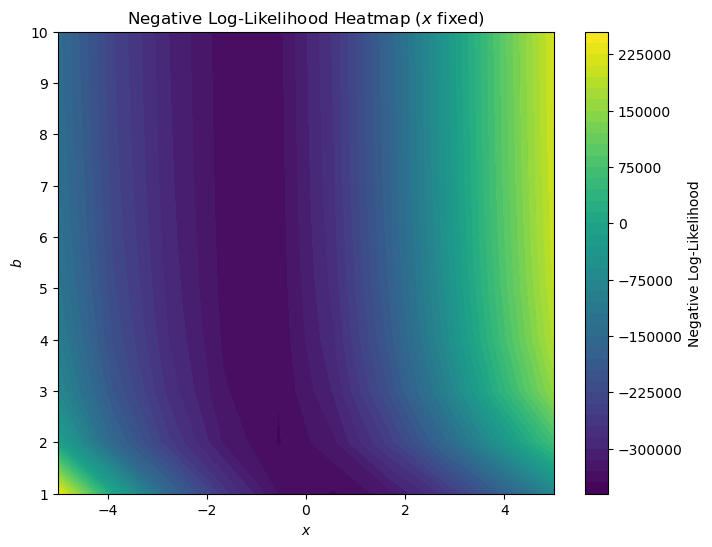

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the parameter grid for m0 and b
x_values = np.linspace(-5, 5, 10)
#m0_values = np.linspace(1.5, 2.5, 10)
b_values = np.linspace(1, 10, 10)

# Calculate likelihoods for a fixed x
#x_fixed = 1.7
m0_fixed = 18
#b_fixed = 0.5
likelihoods = np.zeros((len(x_values), len(b_values)))

for i, x in enumerate(tqdm(x_values)):
    for j, b in enumerate(b_values):
        params = [m0_fixed, b, x]
        likelihoods[i, j] = neg_likelihood(params,apr_mag_r, k_rr, d_desi, apr_mag_r_err)

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(x_values, b_values, likelihoods.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('$x$')
plt.ylabel('$b$')
plt.title('Negative Log-Likelihood Heatmap ($x$ fixed)')
plt.show()

In [13]:
params = [18.358572258469366,0.5762614390624853,1.85]
neg_likelihood(params,apr_mag_r, k_rr, d_desi, apr_mag_r_err)

first term -61307.30133250762
Poisson term 406282.2777231101
N_obs 38715.94355398525


Array(-344974.9763906, dtype=float64)